<a href="https://colab.research.google.com/github/Crall-Lab/SICB2025_CV/blob/main/deepLearningNotebooks/1_training/SICB_CNN_transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Colab!

For this exercise we will be using transfer learning to train a model on a dataset that we create from images grabbed from the internet



*   To execute a tab, click on the left side of the tab (where a play button
*   Double click a tab to show the code
*   Feel free to explore and change things!


In [ ]:
#@title Install python libraries

#!pip install tflite-model-maker
!pip install bing_image_downloader

In [ ]:
#@title import python libraries
from matplotlib import pyplot as plt
import glob
import cv2 as cv
import numpy as np
import os

#from tflite_model_maker.config import ExportFormat
#from tflite_model_maker import model_spec
#from tflite_model_maker import object_detector
#from  tflite_model_maker import image_classifier
from bing_image_downloader import downloader


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
#from tensorflow.keras.preprocessing import image_dataset_from_directory
#from tensorflow.keras.layers.preprocessing import RandomFlip, RandomRotation


# Create your dataset

In [ ]:
search_prompt1 = 'hand making a fist' #@param {type:"string"}
number_images = '75' #@param {type:"string"}
number_images = int(number_images)
downloader.download(search_prompt1, limit=number_images,  output_dir='dataset', force_replace=False, timeout=60,adult_filter_off=False)

gif_test = glob.glob('/content/dataset/'+search_prompt1+'/*')
for ele in gif_test:
  if ele.split('.')[-1] == 'gif':
    os.remove(ele)

In [ ]:
search_prompt1 = 'flat hand' #@param {type:"string"}
number_images = '75' #@param {type:"string"}
number_images = int(number_images)
downloader.download(search_prompt1, limit=number_images,  output_dir='dataset', force_replace=False,adult_filter_off=False, timeout=60)

gif_test = glob.glob('/content/dataset/'+search_prompt1+'/*')
for ele in gif_test:
  if ele.split('.')[-1] == 'gif':
    os.remove(ele)

In [ ]:
search_prompt1 = 'peace sign hand signal' #@param {type:"string"}
number_images = '75' #@param {type:"string"}
number_images = int(number_images)
downloader.download(search_prompt1, limit=number_images,  output_dir='dataset', force_replace=False,adult_filter_off=False, timeout=60)

gif_test = glob.glob('/content/dataset/'+search_prompt1+'/*')
for ele in gif_test:
  if ele.split('.')[-1] == 'gif':
    os.remove(ele)



In [ ]:
#@title To display results
search_prompt1 = 'peace sign hand signal' #@param {type:"string"}

ax = plt.subplot(3,3,1)
allIms = glob.glob('/content/dataset/'+search_prompt1+'/*')
randIms = np.random.permutation(len(allIms))[:9]
cnt = 1
for ele in randIms:
  ax = plt.subplot(3,3,cnt)
  cnt+=1
  tempIm = cv.imread(allIms[ele])[:,:,::-1]
  ax.imshow(tempIm)

In [ ]:
!rm /content/dataset/peace\ sign\ hand\ signal -r

# Preparing your dataset

We'll use tensorflow tools to automatically prepare your dataset based off the directory path, '/content/dataset/, and all the subdirectories within.

By default we'll split the dataset into 85% training data andd 15% validation data (feel free to update)



*   If any GIFs made it into your dataset, be sure to delete them



In [ ]:
from pathlib import Path
import imghdr

data_dir = "/content/dataset/"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "/content/dataset/"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 189 files belonging to 3 classes.
Using 152 files for training.
Found 189 files belonging to 3 classes.
Using 37 files for validation.


In [ ]:
label_list = train_dataset.class_names
out1 = open('/content/labels.txt','w')
labelKey = {}
for ind1,ele in enumerate(label_list):
  if ind1 == len(label_list)-1:
    out1.write('%s %s'%(ind1,ele))
  else:
    out1.write('%s %s \n'%(ind1,ele))
  labelKey[ind1] = ele
out1.close()

# TRAIN YOUR MODEL

in the next few lines of code we will use transfer learning on a pretrained mobilenet-V2 model using the training set and validation set that you created!

In [ ]:
IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

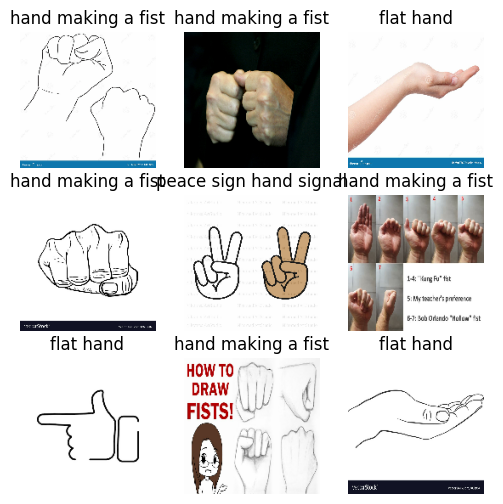

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(6, 6))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_5
predictions


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    # data_augmentation = None
    # data_augmentation.add(None)
    # data_augmentation.add(None)
    # YOUR CODE STARTS HERE
    data_augmentation = tf.keras.Sequential([
  tfl.RandomFlip("horizontal"),
  tfl.RandomRotation(0.2),
])
    # YOUR CODE ENDS HERE

    return data_augmentation

In [ ]:
# GRADED FUNCTION
def sicb_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''


    input_shape = image_shape + (3,)

    # base_model = tf.keras.applications.MobileNetV2(input_shape=None,
    #                                               include_top=False, # <== Important!!!!
    #                                               weights=imagenet) # From imageNet

    # Freeze the base model by making it non trainable
    # base_model.trainable = None

    # create the input layer (Same as the imageNetv2 input size)
    # inputs = tf.keras.Input(shape=None)

    # apply data augmentation to the inputs
    # x = None

    # data preprocessing using the same weights the model was trained on
    # x = preprocess_input(None)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    # x = base_model(None, training=None)

    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    # x = None()(x)
    #include dropout with probability of 0.2 to avoid overfitting
    # x = None(None)(x)

    # create a prediction layer with one neuron (as a classifier only needs one)
    # prediction_layer = None

    # YOUR CODE STARTS HERE

    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(.2)(x)
    prediction_layer = tf.keras.layers.Dense(3)
    # YOUR CODE ENDS HERE

    outputs = prediction_layer(x)
    outputs2 = tf.keras.activations.softmax(outputs)
    model = tf.keras.Model(inputs, outputs2)

    return model

In [ ]:
data_augmentation = data_augmenter()

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
model2 = sicb_model(IMG_SIZE, data_augmentation)

In [ ]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy,
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4025 - loss: 2.0512 - val_accuracy: 0.3514 - val_loss: 2.0665
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7214 - loss: 0.9494 - val_accuracy: 0.6486 - val_loss: 1.3825
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7992 - loss: 0.6299 - val_accuracy: 0.5946 - val_loss: 1.3807
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 919ms/step - accuracy: 0.8880 - loss: 0.2977 - val_accuracy: 0.6757 - val_loss: 1.3410
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8907 - loss: 0.2223 - val_accuracy: 0.5946 - val_loss: 1.2247


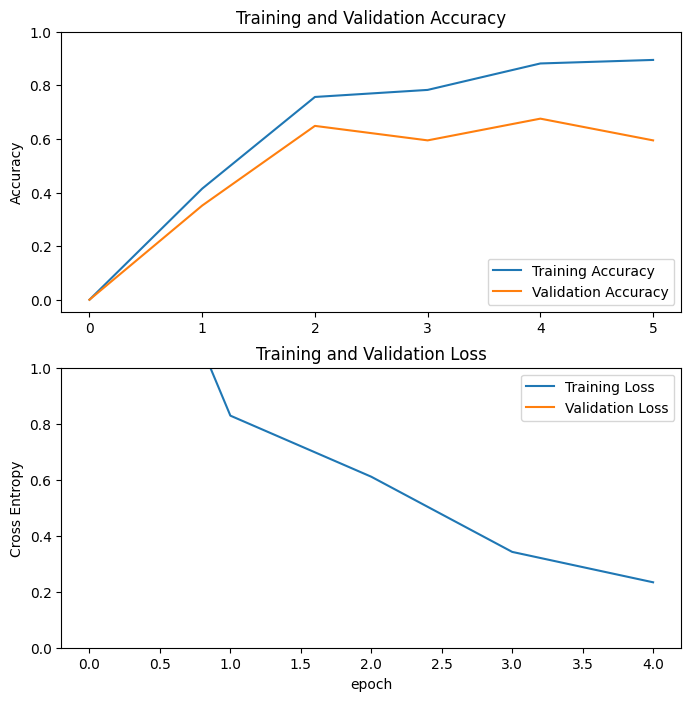

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model2(image_batch)
print(feature_batch.shape)

(32, 3)


Instructions for updating:
Use tf.identity with explicit device placement instead.


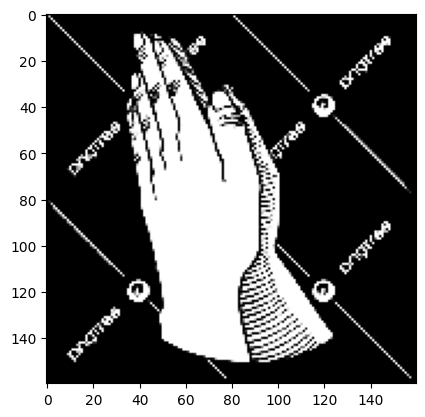

In [ ]:
plt.imshow(image_batch[1,:,:,:].cpu()/255)

In [ ]:
in1 = cv.imread('/content/scissors.jpg')
in2 = np.expand_dims(cv.resize(in1,(160,160)),0)
out1 = model2.predict(in2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


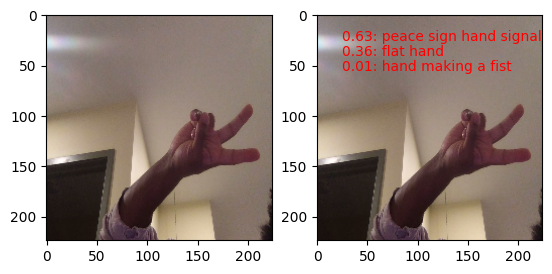

In [ ]:
test = cv.imread('/content/scissors.jpg')[:,:,::-1]
ax = plt.subplot(1,2,1)
test = cv.resize(test,(224,224))
ax.imshow(test)
ax = plt.subplot(1,2,2)
ax.imshow(test)

indy = np.argsort(np.squeeze(out1))[::-1]
conf_final = np.array(np.squeeze(out1))[indy]
lbls_final = [labelKey[ele] for ele in indy]

cnt = 0
for conf1,lbls1 in zip(conf_final,lbls_final):
  conf = np.round(conf1,2)
  plt.text(25,25+(15*cnt),'%s: %s'%(conf,lbls1),color=(1,0,0))
  cnt+=1

In [ ]:
model2.export("/content/model_rps/")

Saved artifact at '/content/model_rps/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_1110')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140050426667856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140050426666624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140050426223904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140050535940688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140050535950720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140050535951776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140050535944032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140050535945440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140050535941216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140050535953536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140050

In [ ]:
# Convert the saved model using TFLiteConverter
converter = tf.lite.TFLiteConverter.from_saved_model('/content/model_rps/')
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable LiteRT ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
tflite_model = converter.convert()

with open('model_rps.tflite', 'wb') as f:
  f.write(tflite_model)